### Gilang Wahyu Nugraha
### 220711879
### Bokeh
### Klasifikasi Jenis Buah Anggur (Merah, Thompson, Concord)
### MobileNet

In [19]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [20]:
count = 0
dirs = os.listdir(r'C:\Users\lenovo\OneDrive\Documents\TubesPMDPM\train_data')
for dir in dirs:
    files = list(os.listdir(r'C:\Users\lenovo\OneDrive\Documents\TubesPMDPM\train_data/'+dir))
    print(dir + ' Folder has ' + str(len(files)) + ' Images')
    count = count + len(files)
print('Images Folder has ' + str(count) + ' Images')

Concord Folder has 100 Images
Merah Folder has 110 Images
Thompson Folder has 100 Images
Images Folder has 310 Images


In [21]:
base_dir = r'C:\Users\lenovo\OneDrive\Documents\TubesPMDPM\train_data'
img_size = 180
batch = 16
validation_split = 0.1

num_classes = 3 

In [22]:
dataset = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed=123, 
    image_size=(img_size, img_size),
    batch_size=batch,
    class_names=['Merah', 'Thompson', 'Concord']
)

Found 310 files belonging to 3 classes.


In [23]:
class_names = dataset.class_names
print("Class Names:", class_names)

expected_classes = ['Merah', 'Thompson', 'Concord']
if set(class_names) != set(expected_classes):
    print("Warning: Kelas yang diambil tidak sesuai dengan yang diharapkan!")

Class Names: ['Merah', 'Thompson', 'Concord']


### Pembagian Dataset menjadi Train, Validation, dan Test dengan rasio 80:10:10

In [24]:
total_count = len(dataset)
train_count = int(total_count * 0.8)
val_count = int(total_count * 0.1)
test_count = total_count - train_count - val_count

if train_count < 0 or val_count < 0 or test_count < 0:
    raise ValueError("Jumlah gambar untuk pelatihan, validasi, atau pengujian tidak valid!")

print("Total Images:", total_count)
print("Train Images:", train_count)
print("Validation Images:", val_count)
print("Test Images:", test_count)

Total Images: 20
Train Images: 16
Validation Images: 2
Test Images: 2


In [25]:
train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count)

print(f"Dataset telah dibagi menjadi {train_count} gambar untuk pelatihan dan {val_count} gambar untuk validasi.")

Dataset telah dibagi menjadi 16 gambar untuk pelatihan dan 2 gambar untuk validasi.


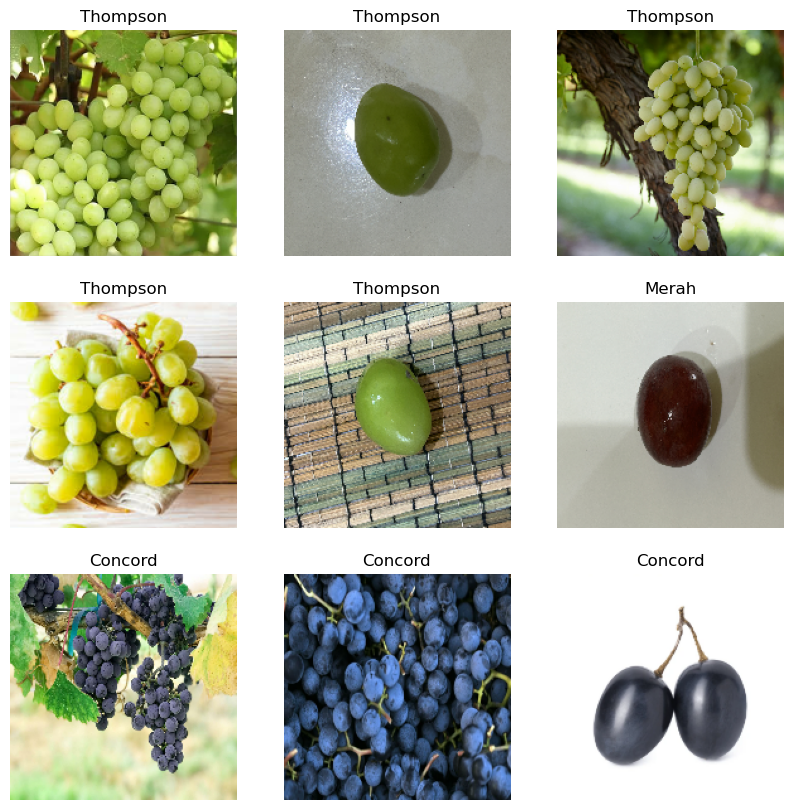

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    num_images_to_display = min(9, len(images))
    for i in range(num_images_to_display):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

plt.show()

In [27]:
import numpy as np

for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)

(16, 180, 180, 3)


In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

c:\Users\lenovo\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


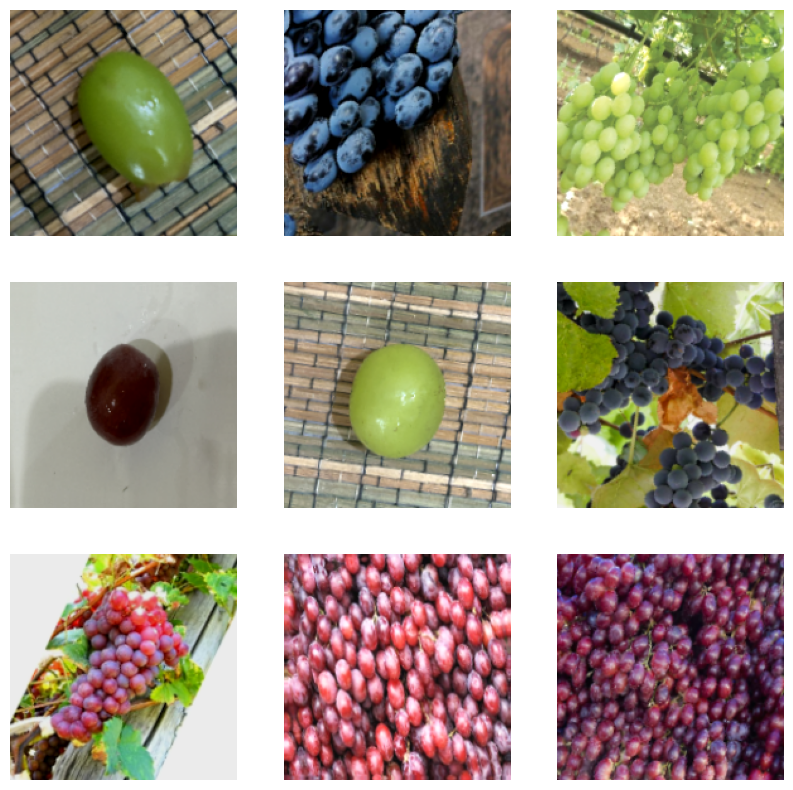

In [29]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1)
])

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    num_images_to_display = min(9, len(images))
    for i in range(num_images_to_display):
        augmented_image = data_augmentation(images[i:i+1])
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype('uint8'))
        plt.axis('off')

plt.show()

In [30]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Membuat model dari awal
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_size, img_size, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

In [31]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 87, 87, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 41, 41, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,619 (1.62 MB)

 Trainable params: 422,659 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=7,
                               mode='max')

history = model.fit(train_ds,
                    epochs=50,
                    validation_data=val_ds,
                    callbacks=[early_stopping])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 555ms/step - accuracy: 0.5065 - loss: 1.1305 - val_accuracy: 0.4259 - val_loss: 1.0868
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 443ms/step - accuracy: 0.8666 - loss: 0.3589 - val_accuracy: 0.4259 - val_loss: 1.0759
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 443ms/step - accuracy: 0.9323 - loss: 0.1850 - val_accuracy: 0.4630 - val_loss: 1.0813
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 447ms/step - accuracy: 0.9626 - loss: 0.1353 - val_accuracy: 0.4630 - val_loss: 1.1073
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 443ms/step - accuracy: 0.9665 - loss: 0.1258 - val_accuracy: 0.5000 - val_loss: 1.1509
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 442ms/step - accuracy: 0.9786 - loss: 0.0842 - val_accuracy: 0.4630 - val_loss: 1.2048
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 445ms/step - accuracy: 0.9957 - loss: 0.0533 - val_accuracy: 0.6481 - val_loss: 1.2614
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 449ms/step - accuracy: 0.9832 - loss: 0.0667 - val_accuracy: 0

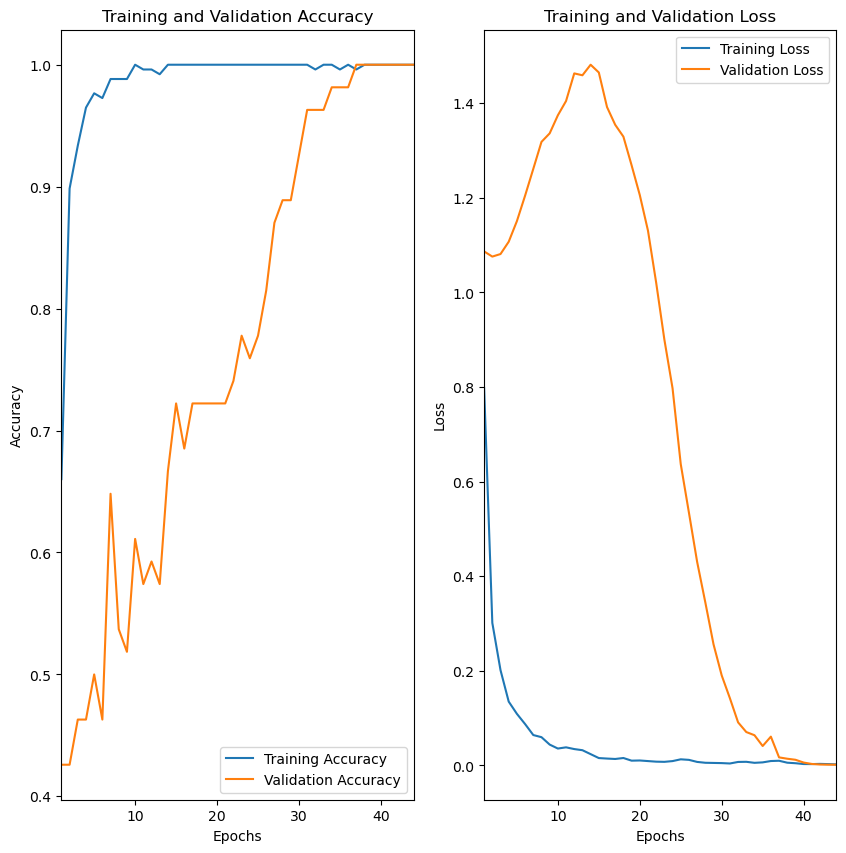

In [33]:
epochs_range = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlim(1, len(epochs_range))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlim(1, len(epochs_range))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
model.save('MobileNet_Bokeh.h5')

In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image

model = load_model(r'C:\Users\lenovo\OneDrive\Documents\TubesPMDPM\MobileNet_Bokeh.h5')
class_names = ['Merah', 'Thompson', 'Concord']

def classify_images(image_path, save_path='predicted_image.jpg'):
    try:
        input_image = tf.keras.utils.load_img(image_path, target_size=(180, 180))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)

        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

result = classify_images(r'C:\Users\lenovo\OneDrive\Documents\TubesPMDPM\test_data\Concord\Concord_Grape_Original_Data010.jpg', save_path='predicted_image.jpg')
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Prediksi: Concord
Confidence: 57.43%
Prediksi: Concord dengan confidence 57.43%. Gambar asli disimpan di predicted_image.jpg.


Found 30 files belonging to 3 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 676ms/step


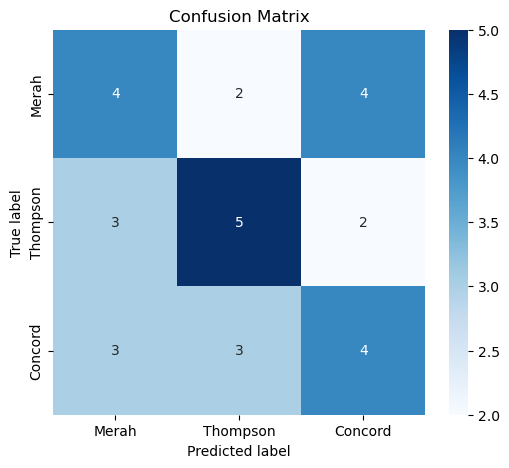

Confusion Matrix:
 [[4 2 4]
 [3 5 2]
 [3 3 4]]
Akurasi: 0.43333333333333335
Presisi: [0.4 0.5 0.4]
Recall: [0.4 0.5 0.4]
F1 Score: [0.4 0.5 0.4]


In [36]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt

model = load_model(r'C:\Users\lenovo\OneDrive\Documents\TubesPMDPM\MobileNet_Bokeh.h5')

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'test_data',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(180, 180)
)

y_pred = model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1)

true_labels = []
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy())
true_labels = tf.convert_to_tensor(true_labels)

conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)

accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

f1_score = 2 * (precision * recall) / (precision + recall)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues',
            xticklabels=["Merah", "Thompson", "Concord"], yticklabels=["Merah", "Thompson", "Concord"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

print("Confusion Matrix:\n", conf_mat.numpy())
print("Akurasi:", accuracy.numpy())
print("Presisi:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())